<a href="https://colab.research.google.com/github/MehaRima/2sxc-content-app/blob/master/Running_Particle_identification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# About

In this programming assignment you will train a classifier to identify type of a particle. There are six particle types: electron, proton, muon, kaon, pion and ghost. Ghost is a particle with other type than the first five or a detector noise. 

Different particle types remain different responses in the detector systems or subdetectors. Thre are five systems: tracking system, ring imaging Cherenkov detector (RICH), electromagnetic and hadron calorimeters, and muon system.

![pid](https://github.com/MehaRima/Advanced-Machine-Learning-Specialization/blob/master/Addressing%20Large%20Hadron%20Collider%20Challenges%20by%20Machine%20Learning/Week2/pic/pid.jpg?raw=1)

You task is to identify a particle type using the responses in the detector systems. 

# Attention

Data files you should download from https://github.com/hse-aml/hadron-collider-machine-learning/releases/tag/Week_2

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip install matplotlib-venn
!apt-get -qq install -y libfluidsynth1
# To determine which version you're using:
!pip show tensorflow

# For the current version: 
!pip install --upgrade tensorflow

# For a specific version:
!pip install tensorflow==1.2

# For the latest nightly build:
!pip install tf-nightly
# https://pypi.python.org/pypi/libarchive
!apt-get -qq install -y libarchive-dev && pip install -U libarchive
import libarchive
!apt-get -qq install python-cartopy python3-cartopy
import cartopy
# https://pypi.python.org/pypi/pydot
!apt-get -qq install -y graphviz && pip install pydot
import pydot

Selecting previously unselected package libfluidsynth1:amd64.
(Reading database ... 144579 files and directories currently installed.)
Preparing to unpack .../libfluidsynth1_1.1.9-1_amd64.deb ...
Unpacking libfluidsynth1:amd64 (1.1.9-1) ...
Setting up libfluidsynth1:amd64 (1.1.9-1) ...
Processing triggers for libc-bin (2.27-3ubuntu1) ...
/sbin/ldconfig.real: /usr/local/lib/python3.6/dist-packages/ideep4py/lib/libmkldnn.so.0 is not a symbolic link

Name: tensorflow
Version: 2.3.0
Summary: TensorFlow is an open source machine learning framework for everyone.
Home-page: https://www.tensorflow.org/
Author: Google Inc.
Author-email: packages@tensorflow.org
License: Apache 2.0
Location: /usr/local/lib/python3.6/dist-packages
Requires: astunparse, opt-einsum, termcolor, protobuf, wrapt, keras-preprocessing, absl-py, tensorboard, tensorflow-estimator, gast, wheel, grpcio, numpy, six, google-pasta, scipy, h5py
Required-by: fancyimpute
Requirement already up-to-date: tensorflow in /usr/local/lib

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas
import numpy
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss
import utils

# Download data

Download data used to train classifiers.

### Read training file

In [4]:
data = pandas.read_csv('training.csv.gz')

In [5]:
data.head()

,TrackP,TrackNDoFSubdetector2,BremDLLbeElectron,MuonLooseFlag,FlagSpd,SpdE,EcalDLLbeElectron,DLLmuon,RICHpFlagElectron,EcalDLLbeMuon,TrackQualitySubdetector2,FlagPrs,DLLelectron,DLLkaon,EcalE,TrackQualityPerNDoF,DLLproton,PrsDLLbeElectron,FlagRICH1,MuonLLbeBCK,FlagHcal,EcalShowerLongitudinalParameter,Calo2dFitQuality,TrackPt,TrackDistanceToZ,RICHpFlagPion,HcalDLLbeElectron,Calo3dFitQuality,FlagEcal,MuonLLbeMuon,TrackNDoFSubdetector1,RICHpFlagProton,RICHpFlagKaon,GhostProbability,TrackQualitySubdetector1,Label,RICH_DLLbeBCK,FlagRICH2,FlagBrem,HcalDLLbeMuon,TrackNDoF,RICHpFlagMuon,RICH_DLLbeKaon,RICH_DLLbeElectron,HcalE,MuonFlag,FlagMuon,PrsE,RICH_DLLbeMuon,RICH_DLLbeProton
0,74791.156263,15.0,0.232275,1.0,1.0,3.2,-2.505719,6.604153,1.0,1.929960,17.585680,1.0,-6.411697,-7.213295,0.000001,1.467550,-26.667494,-2.730674,1.0,-5.152923,1.0,-999.000000,19.954819,3141.930677,0.613640,1.0,-0.909544,-999.000000,1.0,-0.661823,4.0,1.0,1.0,0.018913,5.366212,Muon,-21.913000,1.0,1.0,1.015345,28.0,1.0,-7.213300,-0.280200,5586.589846,1.0,1.0,10.422315,-2.081143e-07,-24.824400
1,2738.489989,15.0,-0.357748,0.0,1.0,3.2,1.864351,0.263651,1.0,-2.061959,20.230680,1.0,5.453014,0.000006,1531.542000,3.570540,-0.711194,1.773806,1.0,-999.000000,0.0,33.187644,0.037601,199.573653,0.465480,1.0,0.434909,13.667366,1.0,-999.000000,10.0,0.0,0.0,0.351206,9.144749,Ghost,-0.703617,0.0,1.0,-2.394644,32.0,1.0,-0.324317,1.707283,-0.000007,0.0,1.0,43.334935,2.771583e+00,-0.648017
2,2161.409908,17.0,-999.000000,0.0,0.0,-999.0,-999.000000,-999.000000,0.0,-999.000000,11.619878,0.0,-999.000000,-999.000000,-999.000000,0.826442,-999.000000,-999.000000,0.0,-999.000000,0.0,-999.000000,-999.000000,94.829418,0.241891,0.0,-999.000000,-999.000000,0.0,-999.000000,5.0,0.0,0.0,0.195717,1.459992,Ghost,-999.000000,0.0,0.0,-999.000000,27.0,0.0,-999.000000,-999.000000,-999.000000,0.0,0.0,-999.000000,-9.990000e+02,-999.000000
3,15277.730490,20.0,-0.638984,0.0,1.0,3.2,-2.533918,-8.724949,1.0,-3.253981,15.336305,1.0,-10.616585,-39.447507,4385.688000,1.076721,-29.291509,-3.053104,1.0,-999.000000,1.0,231.190351,2.839508,808.631064,0.680705,1.0,-1.504160,1939.259641,1.0,-999.000000,9.0,0.0,1.0,0.003972,22.950573,Pion,-47.223118,1.0,1.0,-0.321242,36.0,1.0,-35.202221,-14.742319,4482.803707,0.0,1.0,2.194175,-3.070819e+00,-29.291519
4,7563.700195,19.0,-0.638962,0.0,1.0,3.2,-2.087146,-7.060422,1.0,-0.995816,10.954629,1.0,-8.144945,26.050386,1220.930044,0.439767,21.386587,-2.730648,1.0,-999.000000,1.0,-794.866475,1.209193,1422.569214,0.575066,1.0,-1.576249,1867.165142,1.0,-999.000000,5.0,0.0,0.0,0.015232,3.516173,Proton,15.304688,0.0,1.0,-1.038026,33.0,1.0,25.084287,-10.272412,5107.554680,0.0,1.0,0.000015,-5.373712e+00,23.653087


### List of columns in the samples

Here, **Spd** stands for Scintillating Pad Detector, **Prs** - Preshower, **Ecal** - electromagnetic calorimeter, **Hcal** - hadronic calorimeter, **Brem** denotes traces of the particles that were deflected by detector.

- ID - id value for tracks (presents only in the test file for the submitting purposes)
- Label - string valued observable denoting particle types. Can take values "Electron", "Muon", "Kaon", "Proton", "Pion" and "Ghost". This column is absent in the test file.
- FlagSpd - flag (0 or 1), if reconstructed track passes through Spd
- FlagPrs - flag (0 or 1), if reconstructed track passes through Prs
- FlagBrem - flag (0 or 1), if reconstructed track passes through Brem
- FlagEcal - flag (0 or 1), if reconstructed track passes through Ecal
- FlagHcal - flag (0 or 1), if reconstructed track passes through Hcal
- FlagRICH1 - flag (0 or 1), if reconstructed track passes through the first RICH detector
- FlagRICH2 - flag (0 or 1), if reconstructed track passes through the second RICH detector
- FlagMuon - flag (0 or 1), if reconstructed track passes through muon stations (Muon)
- SpdE - energy deposit associated to the track in the Spd
- PrsE - energy deposit associated to the track in the Prs
- EcalE - energy deposit associated to the track in the Hcal
- HcalE - energy deposit associated to the track in the Hcal
- PrsDLLbeElectron - delta log-likelihood for a particle candidate to be electron using information from Prs
- BremDLLbeElectron - delta log-likelihood for a particle candidate to be electron using information from Brem
- TrackP - particle momentum
- TrackPt - particle transverse momentum
- TrackNDoFSubdetector1  - number of degrees of freedom for track fit using hits in the tracking sub-detector1
- TrackQualitySubdetector1 - chi2 quality of the track fit using hits in the tracking sub-detector1
- TrackNDoFSubdetector2 - number of degrees of freedom for track fit using hits in the tracking sub-detector2
- TrackQualitySubdetector2 - chi2 quality of the track fit using hits in the  tracking sub-detector2
- TrackNDoF - number of degrees of freedom for track fit using hits in all tracking sub-detectors
- TrackQualityPerNDoF - chi2 quality of the track fit per degree of freedom
- TrackDistanceToZ - distance between track and z-axis (beam axis)
- Calo2dFitQuality - quality of the 2d fit of the clusters in the calorimeter 
- Calo3dFitQuality - quality of the 3d fit in the calorimeter with assumption that particle was electron
- EcalDLLbeElectron - delta log-likelihood for a particle candidate to be electron using information from Ecal
- EcalDLLbeMuon - delta log-likelihood for a particle candidate to be muon using information from Ecal
- EcalShowerLongitudinalParameter - longitudinal parameter of Ecal shower
- HcalDLLbeElectron - delta log-likelihood for a particle candidate to be electron using information from Hcal
- HcalDLLbeMuon - delta log-likelihood for a particle candidate to be using information from Hcal
- RICHpFlagElectron - flag (0 or 1) if momentum is greater than threshold for electrons to produce Cherenkov light
- RICHpFlagProton - flag (0 or 1) if momentum is greater than threshold for protons to produce Cherenkov light
- RICHpFlagPion - flag (0 or 1) if momentum is greater than threshold for pions to produce Cherenkov light
- RICHpFlagKaon - flag (0 or 1) if momentum is greater than threshold for kaons to produce Cherenkov light
- RICHpFlagMuon - flag (0 or 1) if momentum is greater than threshold for muons to produce Cherenkov light
- RICH_DLLbeBCK  - delta log-likelihood for a particle candidate to be background using information from RICH
- RICH_DLLbeKaon - delta log-likelihood for a particle candidate to be kaon using information from RICH
- RICH_DLLbeElectron - delta log-likelihood for a particle candidate to be electron using information from RICH
- RICH_DLLbeMuon - delta log-likelihood for a particle candidate to be muon using information from RICH
- RICH_DLLbeProton - delta log-likelihood for a particle candidate to be proton using information from RICH
- MuonFlag - muon flag (is this track muon) which is determined from muon stations
- MuonLooseFlag muon flag (is this track muon) which is determined from muon stations using looser criteria
- MuonLLbeBCK - log-likelihood for a particle candidate to be not muon using information from muon stations
- MuonLLbeMuon - log-likelihood for a particle candidate to be muon using information from muon stations
- DLLelectron - delta log-likelihood for a particle candidate to be electron using information from all subdetectors
- DLLmuon - delta log-likelihood for a particle candidate to be muon using information from all subdetectors
- DLLkaon - delta log-likelihood for a particle candidate to be kaon using information from all subdetectors
- DLLproton - delta log-likelihood for a particle candidate to be proton using information from all subdetectors
- GhostProbability - probability for a particle candidate to be ghost track. This variable is an output of classification model used in the tracking algorithm.

Delta log-likelihood in the features descriptions means the difference between log-likelihood for the mass hypothesis that a given track is left by some particle (for example, electron) and log-likelihood for the mass hypothesis that a given track is left by a pion (so, DLLpion = 0 and thus we don't have these columns). This is done since most tracks (~80%) are left by pions and in practice we actually need to discriminate other particles from pions. In other words, the null hypothesis is that particle is a pion.

### Look at the labels set

The training data contains six classes. Each class corresponds to a particle type. Your task is to predict type of a particle.

In [7]:
set(data.Label)

{'Electron', 'Ghost', 'Kaon', 'Muon', 'Pion', 'Proton'}

Convert the particle types into class numbers.

In [8]:
data['Class'] = utils.get_class_ids(data.Label.values)
set(data.Class)

{0, 1, 2, 3, 4, 5}

### Define training features

The following set of features describe particle responses in the detector systems:

![features](https://github.com/MehaRima/Advanced-Machine-Learning-Specialization/blob/master/Addressing%20Large%20Hadron%20Collider%20Challenges%20by%20Machine%20Learning/Week2/pic/features.jpeg?raw=1)

Also there are several combined features. The full list is following.

In [9]:
features = list(set(data.columns) - {'Label', 'Class'})
features

['RICH_DLLbeProton',
 'MuonLooseFlag',
 'TrackDistanceToZ',
 'SpdE',
 'FlagPrs',
 'FlagHcal',
 'RICHpFlagKaon',
 'FlagMuon',
 'RICH_DLLbeMuon',
 'TrackQualitySubdetector1',
 'EcalShowerLongitudinalParameter',
 'GhostProbability',
 'RICHpFlagElectron',
 'RICHpFlagProton',
 'EcalDLLbeMuon',
 'RICHpFlagPion',
 'MuonLLbeMuon',
 'MuonLLbeBCK',
 'TrackPt',
 'RICH_DLLbeBCK',
 'PrsE',
 'HcalDLLbeElectron',
 'DLLelectron',
 'RICH_DLLbeElectron',
 'DLLkaon',
 'MuonFlag',
 'FlagEcal',
 'FlagBrem',
 'DLLmuon',
 'TrackQualityPerNDoF',
 'FlagSpd',
 'RICH_DLLbeKaon',
 'HcalDLLbeMuon',
 'RICHpFlagMuon',
 'EcalDLLbeElectron',
 'FlagRICH1',
 'TrackP',
 'FlagRICH2',
 'TrackNDoFSubdetector2',
 'TrackNDoFSubdetector1',
 'DLLproton',
 'Calo3dFitQuality',
 'Calo2dFitQuality',
 'TrackNDoF',
 'PrsDLLbeElectron',
 'BremDLLbeElectron',
 'TrackQualitySubdetector2',
 'EcalE',
 'HcalE']

### Divide training data into 2 parts

In [10]:
training_data, validation_data = train_test_split(data, random_state=11, train_size=0.90, test_size=0.10)

In [11]:
len(training_data), len(validation_data)

(1080000, 120000)

In [12]:
training_data.head()

,TrackP,TrackNDoFSubdetector2,BremDLLbeElectron,MuonLooseFlag,FlagSpd,SpdE,EcalDLLbeElectron,DLLmuon,RICHpFlagElectron,EcalDLLbeMuon,TrackQualitySubdetector2,FlagPrs,DLLelectron,DLLkaon,EcalE,TrackQualityPerNDoF,DLLproton,PrsDLLbeElectron,FlagRICH1,MuonLLbeBCK,FlagHcal,EcalShowerLongitudinalParameter,Calo2dFitQuality,TrackPt,TrackDistanceToZ,RICHpFlagPion,HcalDLLbeElectron,Calo3dFitQuality,FlagEcal,MuonLLbeMuon,TrackNDoFSubdetector1,RICHpFlagProton,RICHpFlagKaon,GhostProbability,TrackQualitySubdetector1,Label,RICH_DLLbeBCK,FlagRICH2,FlagBrem,HcalDLLbeMuon,TrackNDoF,RICHpFlagMuon,RICH_DLLbeKaon,RICH_DLLbeElectron,HcalE,MuonFlag,FlagMuon,PrsE,RICH_DLLbeMuon,RICH_DLLbeProton,Class
968874,12192.330089,17.0,-0.170024,0.0,1.0,0.0,-1.831868,-0.996012,1.0,5.017775e-01,23.639733,0.0,-7.273712,-19.783081,-4.186518e-07,3.549970,-22.811781,-3.062694,1.0,-2.853407,1.0,-5079.336440,28.628712,477.872599,0.403936,1.0,-0.924518,1184.381821,1.0,-0.008407,1.0,0.0,1.0,0.301772,2.120835,Ghost,-18.459708,1.0,1.0,1.397398,27.0,1.0,-19.783108,-6.720408,1914.190913,1.0,1.0,1.967353e-06,-2.804208,-25.041909,1
912808,40379.488299,7.0,-999.000000,0.0,0.0,-999.0,-999.000000,-0.792678,1.0,-9.990000e+02,5.240217,0.0,-0.017085,-14.755505,-9.990000e+02,1.268794,-18.450505,-999.000000,0.0,-999.000000,0.0,-999.000000,-999.000000,762.761798,0.795385,1.0,-999.000000,-999.000000,0.0,-999.000000,3.0,1.0,1.0,0.023019,0.364699,Pion,-12.998593,1.0,0.0,-999.000000,13.0,1.0,-14.755493,-2.304893,-999.000000,0.0,1.0,-9.990000e+02,-0.967993,-18.450494,4
30045,5294.729989,12.0,-0.381504,1.0,1.0,3.2,-0.589851,-2.054347,1.0,-2.142670e+00,20.121625,1.0,-1.783970,10.255301,2.258582e+03,1.229169,13.835801,2.359803,1.0,-0.928991,1.0,-232.818100,0.681833,278.262307,0.156057,1.0,-1.607220,421.908218,1.0,-0.268291,12.0,0.0,0.0,0.006190,13.794493,Muon,10.983106,0.0,1.0,0.947490,33.0,1.0,13.137106,-7.920494,2567.385966,1.0,1.0,7.569901e+01,-1.713094,13.416006,3
313784,4645.819821,17.0,-0.417099,1.0,1.0,3.2,0.649028,-8.301831,1.0,7.650223e-07,29.585650,1.0,-5.962948,-22.006813,9.822900e+02,1.447289,-17.656713,-2.730665,1.0,-0.000606,1.0,510.621553,3.820987,296.548215,0.391684,1.0,0.114287,129.041032,1.0,-0.011906,11.0,0.0,0.0,0.024626,8.282235,Ghost,-16.707492,0.0,1.0,-2.394636,37.0,1.0,-22.006791,-24.447692,256.265351,0.0,1.0,1.919901e+00,-7.184691,-17.656691,1
100864,3100.629887,17.0,-0.553602,0.0,1.0,3.2,-2.723420,-12.468398,1.0,-1.438773e+00,10.914584,1.0,-11.139076,0.814791,8.724200e+02,0.644480,1.080291,-2.382539,1.0,-999.000000,1.0,-999.000000,4.541087,144.371037,0.058232,1.0,0.434926,-999.000000,1.0,-999.000000,9.0,0.0,0.0,0.002423,7.402662,Kaon,0.560707,0.0,1.0,-2.394626,36.0,1.0,0.807007,-50.220193,0.000011,0.0,1.0,-8.050605e-07,-9.541493,0.771707,2


In [13]:
training_data[features].describe()

,RICH_DLLbeProton,MuonLooseFlag,TrackDistanceToZ,SpdE,FlagPrs,FlagHcal,RICHpFlagKaon,FlagMuon,RICH_DLLbeMuon,TrackQualitySubdetector1,EcalShowerLongitudinalParameter,GhostProbability,RICHpFlagElectron,RICHpFlagProton,EcalDLLbeMuon,RICHpFlagPion,MuonLLbeMuon,MuonLLbeBCK,TrackPt,RICH_DLLbeBCK,PrsE,HcalDLLbeElectron,DLLelectron,RICH_DLLbeElectron,DLLkaon,MuonFlag,FlagEcal,FlagBrem,DLLmuon,TrackQualityPerNDoF,FlagSpd,RICH_DLLbeKaon,HcalDLLbeMuon,RICHpFlagMuon,EcalDLLbeElectron,FlagRICH1,TrackP,FlagRICH2,TrackNDoFSubdetector2,TrackNDoFSubdetector1,DLLproton,Calo3dFitQuality,Calo2dFitQuality,TrackNDoF,PrsDLLbeElectron,BremDLLbeElectron,TrackQualitySubdetector2,EcalE,HcalE
count,1.080000e+06,1.080000e+06,1.080000e+06,1.080000e+06,1.080000e+06,1.080000e+06,1.080000e+06,1.080000e+06,1.080000e+06,1.080000e+06,1.080000e+06,1.080000e+06,1.080000e+06,1.080000e+06,1.080000e+06,1.080000e+06,1.080000e+06,1.080000e+06,1.080000e+06,1.080000e+06,1.080000e+06,1.080000e+06,1.080000e+06,1.080000e+06,1.080000e+06,1.080000e+06,1.080000e+06,1.080000e+06,1.080000e+06,1.080000e+06,1.080000e+06,1.080000e+06,1.080000e+06,1.080000e+06,1.080000e+06,1.080000e+06,1.080000e+06,1.080000e+06,1.080000e+06,1.080000e+06,1.080000e+06,1.080000e+06,1.080000e+06,1.080000e+06,1.080000e+06,1.080000e+06,1.080000e+06,1.080000e+06,1.080000e+06
mean,-5.229568e+01,1.908407e-01,6.790303e-01,-1.445036e+02,8.510917e-01,7.646630e-01,4.059546e-01,8.207509e-01,-4.926364e+01,6.851082e+00,-4.257734e+02,5.513315e-02,9.514204e-01,2.106120e-01,-1.831246e+02,8.586537e-01,-8.087499e+02,-8.092076e+02,9.282852e+02,-5.210927e+01,-1.340039e+02,-2.353832e+02,-1.403302e+01,-5.109546e+01,-1.452442e+01,1.662343e-01,8.175639e-01,7.918694e-01,-1.268219e+01,1.282943e+00,8.530556e-01,-5.190322e+01,-2.355069e+02,9.186778e-01,-1.829481e+02,8.325130e-01,1.613264e+04,5.016713e-01,1.475204e+01,6.198936e+00,-1.491176e+01,1.003561e+03,-1.674038e+02,2.942315e+01,-1.500610e+02,-2.076723e+02,1.609497e+01,2.346141e+03,2.898032e+03
std,2.153698e+02,3.929640e-01,1.303041e+00,3.546216e+02,3.559983e-01,4.242095e-01,4.910761e-01,3.835609e-01,2.148977e+02,5.071566e+00,5.245722e+03,9.242857e-02,2.149877e-01,4.077435e-01,3.854955e+02,3.483786e-01,3.920690e+02,3.911265e+02,1.605476e+03,2.152615e+02,3.630068e+02,4.234402e+02,1.048488e+02,2.152222e+02,1.074946e+02,3.722910e-01,3.862037e-01,4.059709e-01,1.049807e+02,6.270840e-01,3.540507e-01,2.154569e+02,4.233731e+02,2.733294e-01,3.855809e+02,3.734103e-01,2.753921e+04,4.999974e-01,4.037619e+00,3.115005e+00,1.074610e+02,2.408174e+03,3.969166e+02,6.026995e+00,3.550281e+02,4.054207e+02,7.769702e+00,5.709488e+03,7.656111e+03
min,-9.990000e+02,0.000000e+00,-1.319307e-05,-9.990000e+02,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-9.990000e+02,9.406193e-06,-3.861698e+05,1.456686e-03,0.000000e+00,0.000000e+00,-9.990000e+02,0.000000e+00,-9.990000e+02,-9.990000e+02,1.447011e+00,-9.990000e+02,-9.990000e+02,-9.990000e+02,-9.990000e+02,-9.990000e+02,-9.990000e+02,0.000000e+00,0.000000e+00,0.000000e+00,-9.990000e+02,4.504852e-02,0.000000e+00,-9.990000e+02,-9.990000e+02,0.000000e+00,-9.990000e+02,0.000000e+00,1.115380e+03,0.000000e+00,1.000000e+00,1.000000e+00,-9.990000e+02,-9.990000e+02,-9.990000e+02,7.000000e+00,-9.990000e+02,-9.990000e+02,3.229625e-04,-9.990000e+02,-9.990000e+02
25%,-1.618322e+01,0.000000e+00,2.824411e-01,0.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,1.000000e+00,-4.503437e+00,3.080789e+00,-9.990000e+02,3.852832e-03,1.000000e+00,0.000000e+00,-3.367626e+00,1.000000e+00,-9.990000e+02,-9.990000e+02,2.684007e+02,-1.619943e+01,9.201665e-06,-1.926173e+00,-7.059118e+00,-1.309732e+01,-1.069791e+01,0.000000e+00,1.000000e+00,1.000000e+00,-5.711785e+00,8.856753e-01,1.000000e+00,-1.469696e+01,-3.027614e+00,1.000000e+00,-3.000639e+00,1.000000e+00,4.135297e+03,0.000000e+00,1.300000e+01,4.000000e+00,-1.204060e+01,-9.990000e+02,9.502276e-02,2.600000e+01,-3.062679e+00,-6.250978e-01,1.071093e+01,-3.348990e-06,-1.446553e-05
50%,-2.947544e-06,0.000000e+00,5.136340e-01,3.2000

In [14]:
training_data[features].isnull().any().any()

False

In [15]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
training_scale = scaler.fit_transform(training_data[features].values)

In [16]:
validation_scale = scaler.transform(validation_data[features].values)

# Sklearn classifier

On this step your task is to train **Sklearn** classifier to provide lower **log loss** value.


TASK: your task is to tune the classifier parameters to achieve the lowest **log loss** value on the validation sample you can.



```
# This is formatted as code
**bold text**
from catboost import CatBoostClassifier

gb = CatBoostClassifier(learning_rate=0.05, iterations=1000,task_type='GPU')

gb.fit(training_data[features].values, training_data.Class.values)

```



In [18]:
from sklearn.ensemble import GradientBoostingClassifier

In [19]:
%%time 
gb = GradientBoostingClassifier(learning_rate=0.5, n_estimators=50, subsample=0.8, random_state=13,
                                min_samples_leaf=10, max_depth=3) 
#gb = GradientBoostingClassifier(learning_rate=0.1, n_estimators=50, subsample=0.8, random_state=13, min_samples_leaf=10, max_depth=30) 
#task_type='GPU')
gb.fit(training_scale, training_data.Class.values)



CPU times: user 53min 4s, sys: 1.56 s, total: 53min 6s
Wall time: 53min 7s


### Log loss on the cross validation sample

In [20]:
# predict each track
proba_gb = gb.predict_proba(validation_scale)

In [21]:
log_loss(validation_data.Class.values, proba_gb)

0.5935180887313185

# Keras neural network

On this step your task is to train **Keras** NN classifier to provide lower **log loss** value.


TASK: your task is to tune the classifier parameters to achieve the lowest **log loss** value on the validation sample you can. Data preprocessing may help you to improve your score.

In [22]:

#!pip install tensorflow==2.2 keras.layers.core.Activation(activation)
from keras.models import Sequential
from keras.layers import Dense, Activation

#from keras.layers.core import Dense, Activation
from keras.models import Sequential
from keras.optimizers import Adam
from keras.utils import np_utils
from keras.callbacks import EarlyStopping, ModelCheckpoint

In [23]:
def nn_model(input_dim):
    model = Sequential()
    model.add(Dense(100, input_dim=input_dim))
    model.add(Activation('relu'))
    
    model.add(Dense(50))
    model.add(Activation('relu'))

    model.add(Dense(6))
    model.add(Activation('softmax'))

    model.compile(loss='categorical_crossentropy', optimizer=Adam())
    return model

In [25]:
callback = [EarlyStopping(monitor='val_loss', min_delta=0, patience=4, verbose=0, mode='auto'),
            ModelCheckpoint('output/{val_loss:.4f}.hdf5', monitor='val_loss', verbose=1, save_best_only=True, mode='auto')]

In [26]:
nn = nn_model(len(features))
nn.fit(training_scale, np_utils.to_categorical(training_data.Class.values),
       validation_data=(validation_scale, np_utils.to_categorical(validation_data.Class.values)),
       epochs=50, verbose=1, batch_size=256, callbacks=callback)

Epoch 1/50
4205/4219 [============================>.] - ETA: 0s - loss: 0.8178
Epoch 00001: val_loss improved from inf to 0.62394, saving model to output/0.6239.hdf5
4219/4219 [==============================] - 7s 2ms/step - loss: 0.8173 - val_loss: 0.6239
Epoch 2/50
4218/4219 [============================>.] - ETA: 0s - loss: 0.6196
Epoch 00002: val_loss improved from 0.62394 to 0.60159, saving model to output/0.6016.hdf5
4219/4219 [==============================] - 6s 2ms/step - loss: 0.6196 - val_loss: 0.6016
Epoch 3/50
4218/4219 [============================>.] - ETA: 0s - loss: 0.6051
Epoch 00003: val_loss did not improve from 0.60159
4219/4219 [==============================] - 6s 2ms/step - loss: 0.6051 - val_loss: 0.6038
Epoch 4/50
4187/4219 [============================>.] - ETA: 0s - loss: 0.5962
Epoch 00004: val_loss improved from 0.60159 to 0.59220, saving model to output/0.5922.hdf5
4219/4219 [==============================] - 6s 2ms/step - loss: 0.5962 - val_loss: 0.5922


In [29]:
#nn.load_weights('output/0.5680.hdf5')

### Log loss on the cross validation sample

In [30]:
# predict each track
proba_nn = nn.predict_proba(validation_scale)

In [31]:
log_loss(validation_data.Class.values, proba_nn)

0.5692699768065895

# Quality metrics

Plot ROC curves and signal efficiency dependece from particle mometum and transverse momentum values.

In [32]:
proba = proba_nn

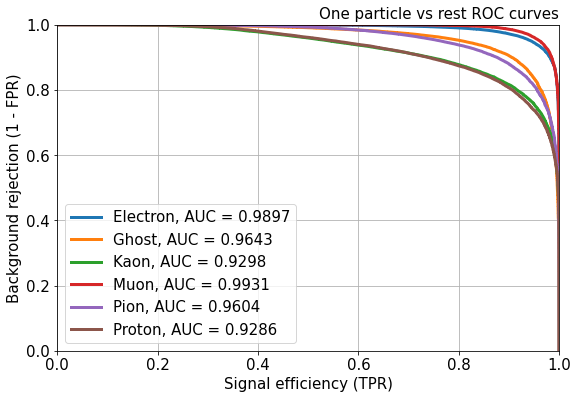

In [33]:
utils.plot_roc_curves(proba, validation_data.Class.values)

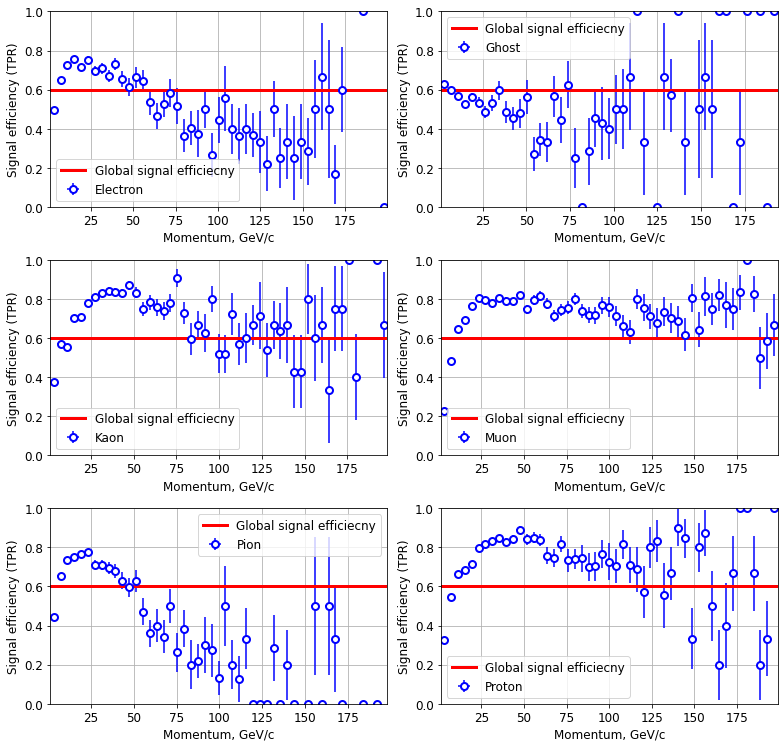

In [34]:
utils.plot_signal_efficiency_on_p(proba, validation_data.Class.values, validation_data.TrackP.values, 60, 50)
plt.show()

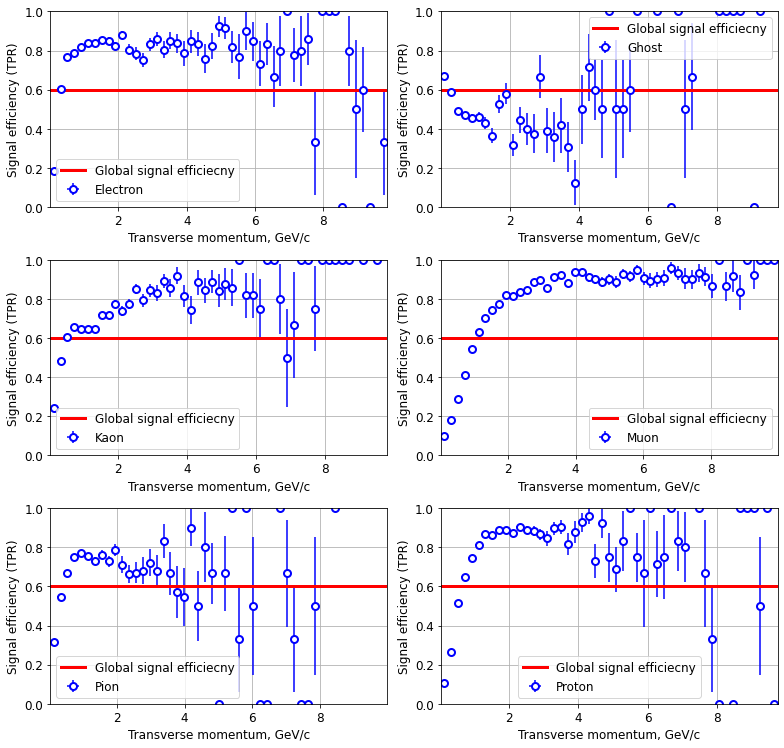

In [35]:
utils.plot_signal_efficiency_on_pt(proba, validation_data.Class.values, validation_data.TrackPt.values, 60, 50)
plt.show()

# Prepare submission

Select your best classifier and prepare submission file.

In [36]:
test = pandas.read_csv('test.csv.gz')

In [37]:
best_model = nn

In [38]:
test_scale = scaler.transform(test[features])

In [39]:
# predict test sample
submit_proba = best_model.predict_proba(test_scale)
submit_ids = test.ID

In [40]:
from IPython.display import FileLink
utils.create_solution(submit_ids, submit_proba, filename='submission_file.csv.gz')

/content/submission_file.csv.gz